In [1]:

import numpy as np
import random
import pywt

In [2]:
np.random.seed(100)
a = np.random.randint(low=0,high=351, size=(10,2))
a.shape
a

array([[  8, 280],
       [323, 343],
       [ 79, 350],
       [ 53,  66],
       [226,  14],
       [290, 240],
       [280, 143],
       [228, 316],
       [ 58, 137],
       [ 93,  86]])

#We can generate the same random numbers everytime. 


# Function to compue the spr of a sampling 

In [3]:
def apply_Fu(sampling_pattern, x):
    # compute subsampled FFT
    return sampling_pattern*np.fft.fftshift(np.fft.fft2(x))

def apply_Fu_adjoint(sampling_pattern, y):
    return np.fft.ifft2(np.fft.ifftshift(sampling_pattern*y))
    

def spr(gridsize, sampling_pattern):
    # gridsize should be 2-element tuple, e.g. gridsize = (10, 10)
    maxima = np.zeros(gridsize,dtype = np.complex)
    for x in range(gridsize[0]):
        for y in range(gridsize[1]):
            # in this iteration, the index "i" corresponds to the gridpoint (x, y)

            # construct basis vector
            e_i = np.zeros(gridsize,dtype = np.complex)
            e_i[x, y] = 1

            # compute psf_i = Fu* Fu e_i
            # psf_i[xx, yy] is PSF(i,j) if index "j" corresponds to gridpoint (xx, yy)
            psf_i = apply_Fu_adjoint(sampling_pattern, apply_Fu(sampling_pattern, e_i))

            # normalize; psf_i[x, y] is PSF(i,i)
            psf_i = psf_i / psf_i[x, y]

            # trick to exclude point "i" itself from maximum: set it to -infinity
            psf_i[x, y] = -np.inf

            # "inner" maximum, over "j"
            maxima[x, y] = np.max(psf_i)
    spr = np.max(maxima)
    return spr

# Function to compue the spr of a sampling
## this uses the tpsf

In [4]:
#takes forever to compute. it is based on the previous function and thus uses the same apply_Fu and apply_Fu_adjoint

def re_sparce(x,slices):
    coeffs_processed = pywt.array_to_coeffs(x,slices,output_format='wavedec2')
    img_r = pywt.waverec2(coeffs_processed,"db5",mode="periodization")
    return img_r

def apply_Sp(x,lv=None):
    C =pywt.wavedec2(x,"db5",mode="periodization",level = lv)
    arr,coeff_slices = pywt.coeffs_to_array(C)
    return arr

def apply_Fu(sampling_pattern, x):
    # compute subsampled FFT
    return sampling_pattern*np.fft.fftshift(np.fft.fft2(x))

def apply_Fu_adjoint(sampling_pattern, y):
    return np.fft.ifft2(np.fft.ifftshift(sampling_pattern*y))
    

def tspr(gridsize, sampling_pattern,lvl=None):
    # gridsize should be 2-element tuple, e.g. gridsize = (10, 10)
    #level specifies the level of the wavelet transform
    
    #extract the shape of the used wavelet transform so that a point can be brought back from wavelet to image space
    C =pywt.wavedec2(sampling_pattern,"db5",mode="periodization",level=lvl)
    coeff_slices = pywt.coeffs_to_array(C,padding=0)[1]
    
    maxima = np.zeros(gridsize,dtype = np.complex)
    for x in range(gridsize[0]):
        for y in range(gridsize[1]):
            # in this iteration, the index "i" corresponds to the gridpoint (x, y)

            # construct basis vector
            e_i = np.zeros(gridsize,dtype = np.complex)
            e_i[x, y] = 1

            # compute psf_i = Fi Fu* Fu Fi* e_i
            # psf_i[xx, yy] is PSF(i,j) if index "j" corresponds to gridpoint (xx, yy)
            psf_i = apply_Sp(apply_Fu_adjoint(sampling_pattern, apply_Fu(sampling_pattern, re_sparce(e_i,coeff_slices))),lvl)

            # normalize; psf_i[x, y] is PSF(i,i)
            psf_i = psf_i / psf_i[x, y]

            # trick to exclude point "i" itself from maximum: set it to -infinity
            psf_i[x, y] = -np.inf

            # "inner" maximum, over "j"
            maxima[x, y] = np.max(psf_i)
    spr = np.max(maxima)
    return spr

# 1   Uniform Random Undersampling:



In [5]:
np.random.seed(10)
a = np.random.randint(low=0,high=351, size=(15488,2))
a.shape
a

array([[265, 125],
       [ 15, 320],
       [123, 156],
       ...,
       [ 84,  88],
       [106,  96],
       [278, 131]])

In [6]:
b = np.zeros((352,352),dtype=np.complex_)
b

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

Let's generalize the uniform random undersampling

In [7]:
def uniformrandom(x):
    import math
    np.random.seed(11)
    a = np.random.randint(low=0,high=x.shape[0]-1, size= (math.floor(0.33*x.shape[0]*x.shape[1]),2))  #33% of the total data
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for (i,j) in a:
        b[i,j] = x[i,j]
        
    b = b.astype(bool).astype(int)
    return b

In [11]:
import cv2
img = cv2.imread('brain.jpeg',0)

In [12]:
from scipy import fftpack

In [13]:
original = np.fft.fft2(img)

center = np.fft.fftshift(original)

inv_center = np.fft.ifftshift(center)

processed_img = np.fft.ifft2(inv_center)


In [14]:
unifrandmatrix = uniformrandom(center)    #x in the original function can be arbitrary square matrix

In [15]:
unifrandmatrix

array([[1, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

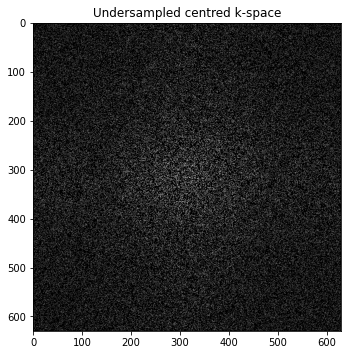

In [16]:
import matplotlib.pyplot as plt
b = center*unifrandmatrix
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

(<AxesSubplot:title={'center':'Back to undersampled k-space'}>,
 Text(0.5, 1.0, 'Back to undersampled k-space'))

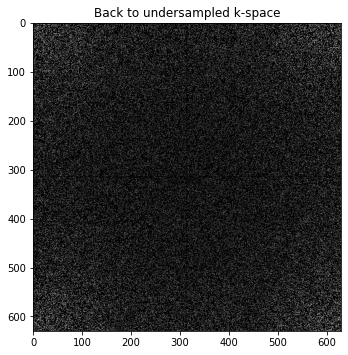

In [17]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
inv_b = np.fft.ifftshift(b)
plt.subplot(154), plt.imshow(np.log(1+np.abs(inv_b)), "gray"), plt.title("Back to undersampled k-space")

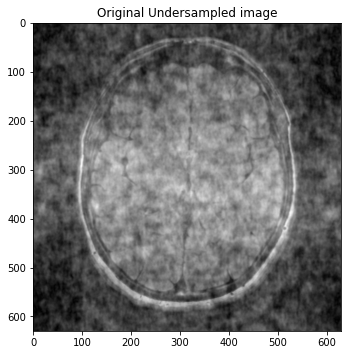

In [18]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [19]:
img

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 6, 6, 6],
       ...,
       [5, 5, 5, ..., 6, 6, 6],
       [5, 5, 5, ..., 6, 6, 6],
       [5, 5, 5, ..., 6, 6, 6]], dtype=uint8)

In [20]:
#spr((352,352), unifrandmatrix)

# 2. Undersampling Parallel Lines of the K-space. 

In [21]:
def randomline(x):
    import math
    np.random.seed(10)
    a = np.random.randint(low=0,high=x.shape[0]-1, size= (math.floor(0.33*x.shape[1])))
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for j in a:
        b[:,j] = x[:,j]

    b = b.astype(bool).astype(int)
    return b

In [22]:
randomline_ = randomline(center) 

In [23]:
randomline_

array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

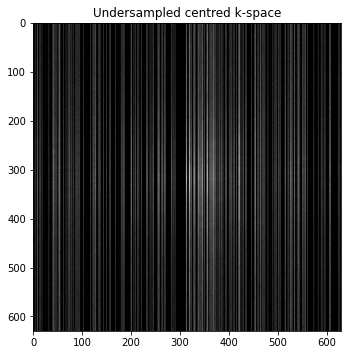

In [24]:
import matplotlib.pyplot as plt
b = center*randomline_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

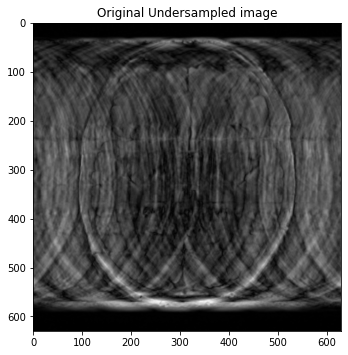

In [25]:
inv_b = np.fft.ifftshift(b)
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [26]:
#spr((352,352), randomline)

# 3. Gaussian Distribution Undersampling

In [27]:
def randomgauss(x):
    import math
    np.random.seed(3)
    
    mu, sigma = math.floor(0.5*x.shape[1]), math.floor(0.1*x.shape[1])
    s = np.random.normal(mu, sigma, size = (math.floor(0.33*x.shape[0]*x.shape[1]),2))
    s = s.round().astype(int)

    b = np.zeros((x.shape), dtype = np.complex_)
    
    for (i,j) in s:
        b[i,j] = center[i,j]

    b = b.astype(bool).astype(int)
    return b

In [28]:
randomgauss_ = randomgauss(center) 

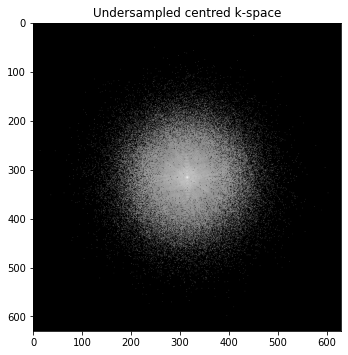

In [29]:
import matplotlib.pyplot as plt
b = center*randomgauss_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

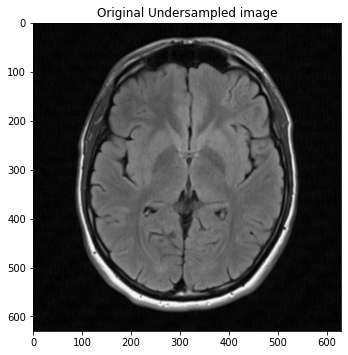

In [30]:
inv_b = np.fft.ifftshift(b)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [31]:
#spr((352,352), randomgauss)

# 4. Binomial Undersampling

In [32]:
def randombinomial(x):
    np.random.seed(10)
    import math
    n, p = math.floor(x.shape[0]), .5
    s = np.random.binomial(n, p, size = (math.floor(0.33*x.shape[0]*x.shape[1]),2))
    s = s.round().astype(int)
                   
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for (i,j) in s:
        b[i,j] = x[i,j]

    b = b.astype(bool).astype(int)
    return b
    

In [33]:
randombinomial_ = randombinomial(center)

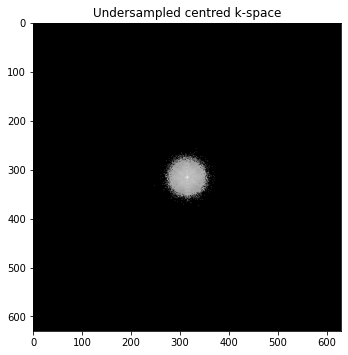

In [34]:
import matplotlib.pyplot as plt
b = center*randombinomial_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

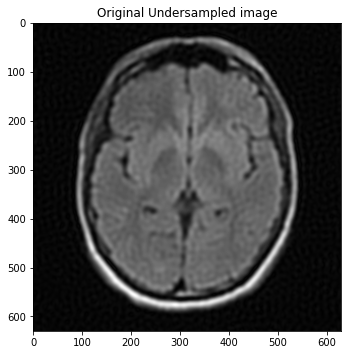

In [35]:
inv_b = np.fft.ifftshift(b)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [36]:
#spr((352,352), randombinomial)

# 5. Skellam Distribution:

In [37]:
def randomskellam(x):
    import math
    from scipy.stats import skellam
    np.random.seed(10)
    mu1, mu2 = math.floor(0.5*x.shape[0]), .5
    s = skellam.rvs(mu1, mu2, size=(math.floor(0.33*x.shape[0]*x.shape[1]),2))

    s = s.round().astype(int)
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for (i,j) in s:
        b[i,j] = x[i,j]

    b = b.astype(bool).astype(int)
    return b

In [38]:
randomskellam_ = randomskellam(center)

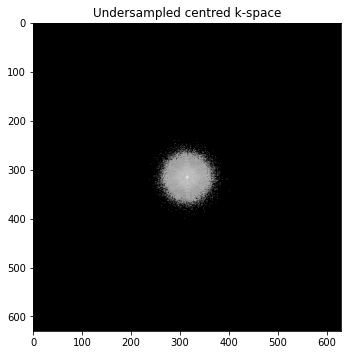

In [39]:
import matplotlib.pyplot as plt
b = center*randomskellam_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

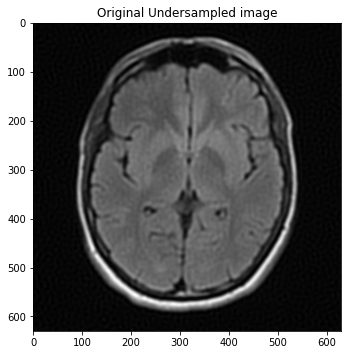

In [40]:
inv_b = np.fft.ifftshift(b)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [41]:
#spr((352,352), randomskellam)

# 6. Spiral Undersampling:

In [42]:
#this can generate some stangeshapes for the sampling the spr is good but the reconstruckted image from the sample is bad withouth a working algorithm
def spiral(x):
    import math
    #the code calculated a double spiral so it didnt seem to be a lot of work to make the sample be double spiral
    def fermat_spiral_double(dot,size=64):
        dot=int(dot)
        correction=1
        if size!=64:
            correction = size/64 
        data=[]    
        d=dot*0.01
        for i in range(dot): 
            t = i / d * np.pi
            x = int((((1 +  t) * math.cos(3*t))-32)*correction) #even numbers and uneven numbers for x in x*t produce two different kind of shapes 
            y = int((((1 +  t) * math.sin(1*t))-32)*correction) # 3/4 cos/sin is a nice shape 
            negx = int(((-(1 +  t) * math.cos(3*t))-32)*correction)
            negy = int(((-(1 +  t) * math.sin(1*t))-32)*correction)
            if [x,y] not in data: 
                if x> -size and y> -size and x<=0 and y<=0:
                    data.append([x,y])
            if [negx,negy] not in data:
                if negx>-size and negy>-size and negx<=0 and negy<=0:
                    data.append([negx,negy])
        narr = np.array(data)

        return -narr

    f_spiral = fermat_spiral_double(int((x.shape[0]*x.shape[1])),x.shape[0])
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for (i,j) in f_spiral:
        b[i,j] = x[i,j]

    b = b.astype(bool).astype(int)
    return b

In [43]:
spiral_ = spiral(center)

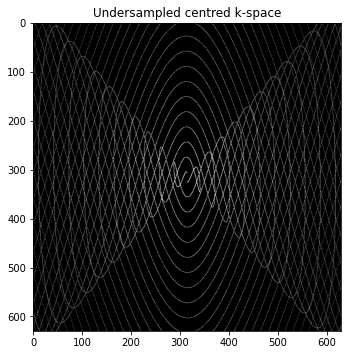

In [44]:
import matplotlib.pyplot as plt
b = center*spiral_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

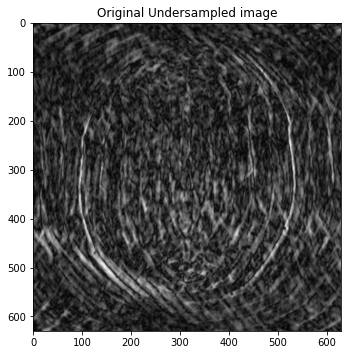

In [45]:
inv_b = np.fft.ifftshift(b)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [46]:
#spr((352,352), spiral)

# 7. Gaussian Distribution Line Undersampling:

In [47]:
def gaussline(x):
    import math
    np.random.seed(10)
    
    mu, sigma = math.floor(0.5*x.shape[1]), math.floor(0.2*x.shape[1])
    s = np.random.normal(mu, sigma, size = (math.floor(0.33*x.shape[0])))
    s = s.round().astype(int)
    true_list=[]
    max_allowed = max(x.shape)-1
    for item in s:
        if item <= max_allowed and item >= 0 and (item not in true_list):
            true_list.append(item)
    else:
        while True:
            a = int(np.random.normal(mu, sigma))
            if a <= max_allowed and a >= 0 and (a not in true_list):
                true_list.append(a)
                break
    b = np.zeros((x.shape), dtype = np.complex_)
    
    for j in s:
        b[:,j] = x[:,j]

    b = b.astype(bool).astype(int)
    return b

In [48]:
gaussline_ = gaussline(center)

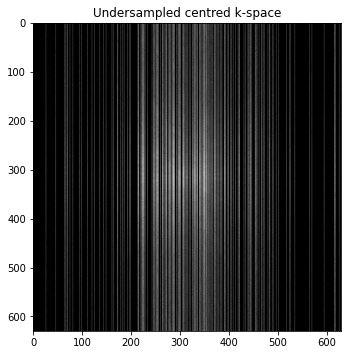

In [49]:
import matplotlib.pyplot as plt
b = center*gaussline_
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(154), plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")

plt.show()

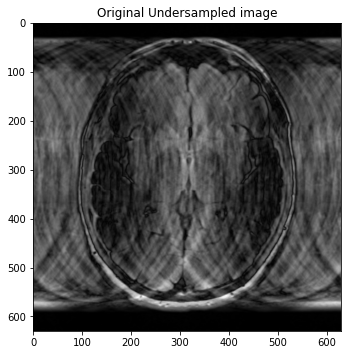

In [50]:
inv_b = np.fft.ifftshift(b)

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
b_image = np.fft.ifft2(inv_b)
plt.subplot(155), plt.imshow(np.abs(b_image), "gray"), plt.title("Original Undersampled image")

plt.show()

In [51]:
#spr((352,352),gausslin)

#  multiple slice of diferent line samples following the gaussian destribution 

In [52]:
def gaussline_multiple(x,slices):
    import math
    l=[]
    max_allowed = max(x.shape)-1
    for i in range(slices):
        np.random.seed(i)
        mu, sigma = math.floor(0.5*x.shape[1]), math.floor(0.2*x.shape[1])
        s = np.random.normal(mu, sigma, size = (math.floor(0.33*x.shape[0])))
        s = s.round().astype(int)
        true_list = []
        for item in s:
            if item <= max_allowed and item >= 0 and (item not in true_list):
                        true_list.append(item)
            else:
                while True:
                    a = int(np.random.normal(mu, sigma))
                    if a <= max_allowed and a >= 0 and (a not in true_list):
                        true_list.append(a)
                        break             
        b = np.zeros((x.shape), dtype = np.complex_)
        for j in true_list:
            b[:,j] = center[:,j]

        b = b.astype(bool).astype(int)
        l.append(b)
    return np.array(l)

In [53]:
gaussline_m = gaussline_multiple(center,10)

# Wavelets

The following is a test to see what happens when we do what we have been doing earlier with an image that requires the wavelet transform. I only did this on gaussian lines.

Text(0.5, 1.0, 'image of a brain')

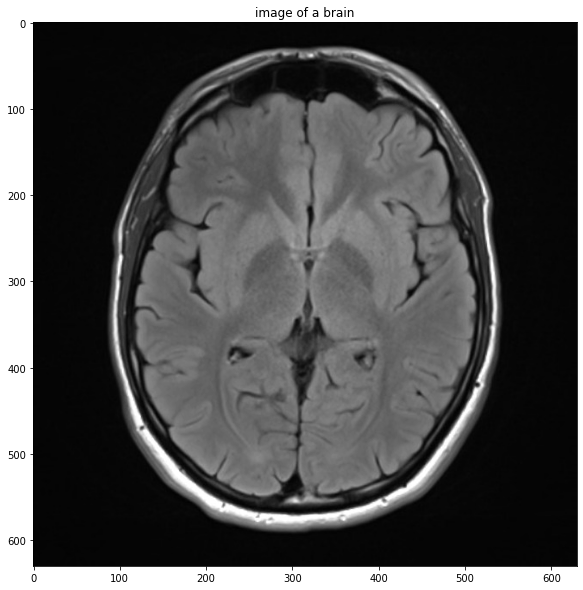

In [54]:
img = cv2.imread("brain.jpeg",0)
plt.figure(figsize=(10,10))
plt.imshow(img,cmap=plt.cm.gray)
plt.title("image of a brain")


Text(0.5, 1.0, 'level max wavelet')

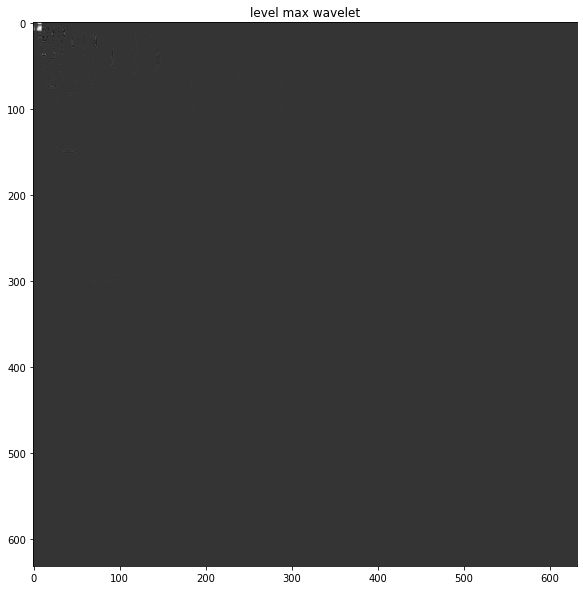

In [55]:

C =pywt.wavedec2(img,"db5",mode="periodization",level=None)
arr,coeff_slices = pywt.coeffs_to_array(C,padding=0)
plt.figure(figsize=(10,10))
plt.imshow(arr,cmap=plt.cm.gray)
plt.title("level max wavelet")



Text(0.5, 1.0, 'level max wavelet')

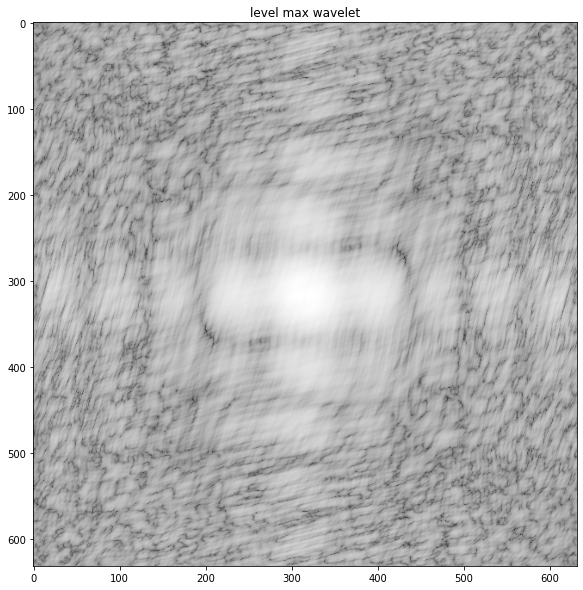

In [56]:
original = np.fft.fft2(arr)
center_ = np.fft.fftshift(original)
plt.figure(figsize=(10,10))
plt.imshow(np.log(1+np.abs(center_)),cmap=plt.cm.gray)
plt.title("level max wavelet")



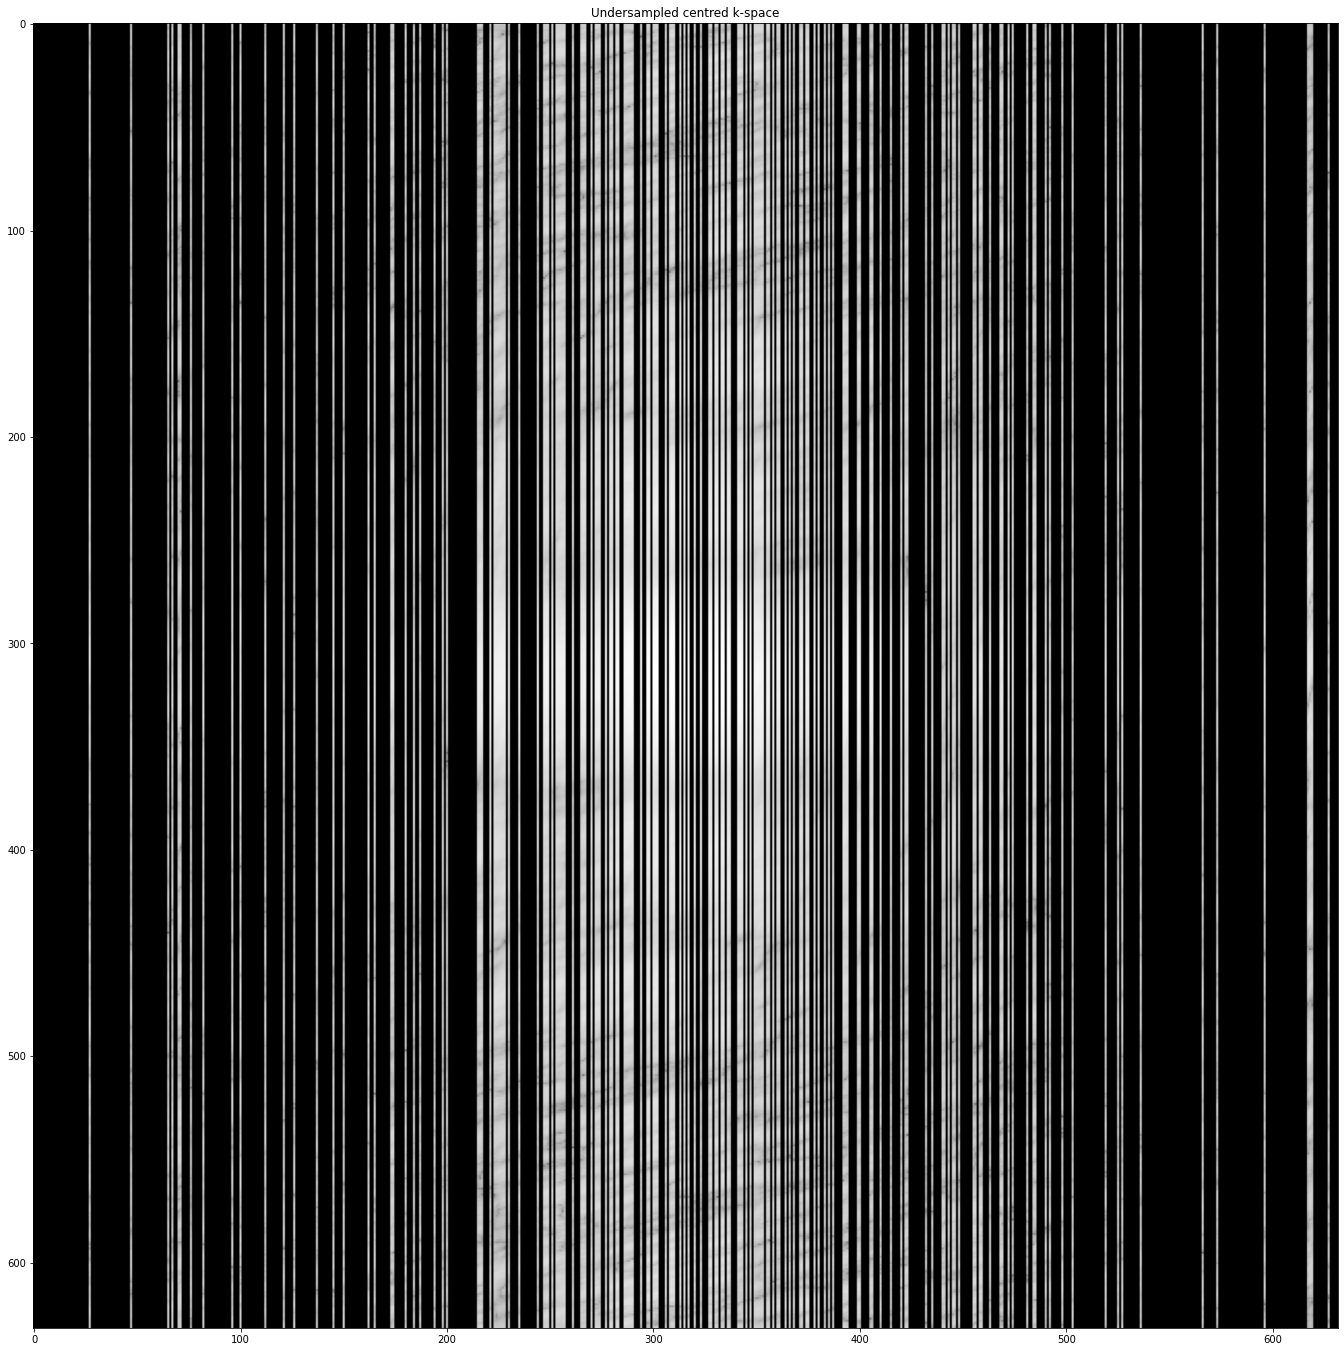

In [57]:
#gaussline = gaussline(center)
gauss_lines = gaussline(center_) 
b = center_*gauss_lines
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.imshow(np.log(1+np.abs(b)), "gray"), plt.title("Undersampled centred k-space")
plt.show()


<ipython-input-58-00fd15b2043c>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  img_r=np.uint8(img_r)


Text(0.5, 1.0, 'restored image')

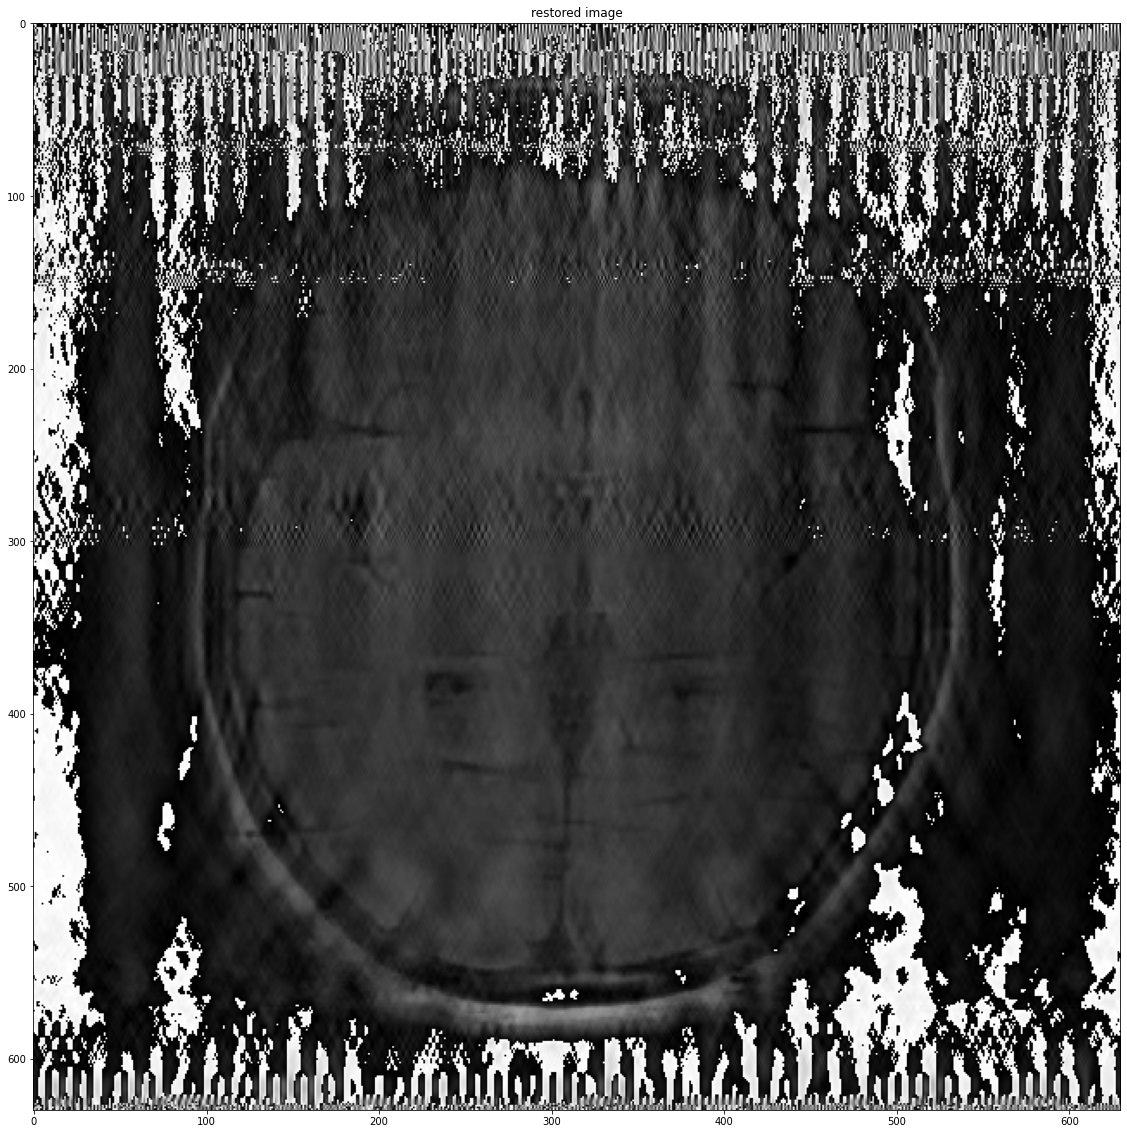

In [58]:

inv_b = np.fft.ifftshift(b)
b_image = np.fft.ifft2(inv_b)
coeffs_processed = pywt.array_to_coeffs(b_image,coeff_slices,output_format='wavedec2'
)
img_r = pywt.waverec2(coeffs_processed,"db5",mode="periodization")
img_r=np.uint8(img_r)
plt.figure(figsize=(20,20))
plt.imshow(img_r,cmap=plt.cm.gray)
plt.title("restored image")

## Bacuse our spr implementation takes forever to compute we will campute the spr with smaller samples (64x64 pixels). 

In [59]:
# Warning! Some seeds may result in empty samples
# Do not use uniformrandom with seed 10 and size 64 the resulting sample matrix consists only of zeros
def lazy(distr):
    test_matrix = np.ones((64,64))
    for dist in distr:
        test = dist(test_matrix)
        print(f"Used function {str(dist)}")
        print(f"tpsf: {abs(tspr((64,64),test))}")
        print(f"psf: {abs(spr((64,64),test))}")
        print()

In [60]:
all_dist=[uniformrandom,randomline,randomgauss,randombinomial,randomskellam,spiral,gaussline]

In [61]:
lazy(all_dist)

Used function <function uniformrandom at 0x1131aa5e0>
tpsf: 0.20055344245137532
psf: 0.06552949934433026

Used function <function randomline at 0x1246474c0>
tpsf: 0.6839144611158474
psf: 0.2663255933086922

Used function <function randomgauss at 0x1250749d0>
tpsf: 7.086249196415152
psf: 0.7657468149868694

Used function <function randombinomial at 0x1273e2430>
tpsf: 65.19923634537298
psf: 0.8644211484409964

Used function <function randomskellam at 0x1287624c0>
tpsf: 9.039210895862341
psf: 0.7833628240777097

Used function <function spiral at 0x11f990550>
tpsf: 0.24590658498280935
psf: 0.1951523324891494

Used function <function gaussline at 0x123b8ca60>
tpsf: 0.5706698132221109
psf: 0.4519832659692045

